In [1]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

In [10]:
url_front = 'http://data.insideairbnb.com/singapore/sg/singapore/'
url_end_calendars = '/data/calendar.csv.gz'

# Combine Data

In [11]:
dates = ['2019-03-18', '2019-04-20', '2019-05-23', '2019-06-25', '2019-07-21', '2019-08-28', '2019-09-25', '2019-10-25', '2019-11-26', '2019-12-28',
         '2020-01-26', '2020-02-27', '2020-03-21', '2020-04-26', '2020-05-27', '2020-06-22', '2020-10-26', '2020-11-27', '2020-12-29','2021-01-27']

In [12]:
calendars = []

In [13]:
for date in dates:
    # print(date)
    calendar = pd.read_csv(url_front + date + url_end_calendars)
    calendars.append(calendar)

In [14]:
calendars_full = calendars[0]
for i in range(1, len(dates)-1):
    calendars_full = pd.concat([calendars_full, calendars[i]])

In [15]:
calendars_full.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,49091,2019-03-18,t,$81.00,$81.00,180.0,360.0
1,49091,2019-03-19,t,$81.00,$81.00,180.0,360.0
2,49091,2019-03-20,t,$81.00,$81.00,180.0,360.0
3,49091,2019-03-21,t,$81.00,$81.00,180.0,360.0
4,49091,2019-03-22,t,$81.00,$81.00,180.0,360.0


In [16]:
calendars_full.shape

(50721752, 7)

In [17]:
calendars_full['price'].isnull().value_counts()

False    50718004
True         3748
Name: price, dtype: int64

In [18]:
calendars_full['adjusted_price'].isnull().value_counts()

False    50718004
True         3748
Name: adjusted_price, dtype: int64

In [19]:
# drop duplicate rows & do not have price data
calendars_full = calendars_full.drop_duplicates()
calendars_full = calendars_full.dropna(subset = ['price'])

In [20]:
calendars_full.shape

(21193818, 7)

In [21]:
calendars_full.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,49091,2019-03-18,t,$81.00,$81.00,180.0,360.0
1,49091,2019-03-19,t,$81.00,$81.00,180.0,360.0
2,49091,2019-03-20,t,$81.00,$81.00,180.0,360.0
3,49091,2019-03-21,t,$81.00,$81.00,180.0,360.0
4,49091,2019-03-22,t,$81.00,$81.00,180.0,360.0


### EDA 3.2: Prices of Accommodations Rise During the December-February Period

In [22]:
calendars_full['month'] = calendars_full['date'].apply(lambda x: x[0:7])

In [27]:
# delete all the month in the future
lst_date = dates[-1]
calendars_full = calendars_full.query('month <= @lst_date')
calendars_full['month'].value_counts()

2020-03    1099351
2020-05    1065684
2020-04    1042684
2020-01    1024282
2020-06    1008412
2019-12     995527
2020-07     960830
2020-02     960616
2020-08     874499
2019-11     867051
2019-10     825844
2020-09     773803
2020-12     759264
2020-11     755403
2020-10     750601
2021-01     719878
2019-09     715600
2019-08     628955
2019-07     579298
2019-06     454794
2019-05     379309
2019-04     281928
2019-03     111622
Name: month, dtype: int64

In [28]:
calendars_full['price'] = calendars_full['price'].apply(lambda x: float(x[1:-3].replace(',', '')))
calendars_full.head(2)

In [30]:
# get mean price of each month
calendars_mean = calendars_full[['listing_id', 'month', 'price']].groupby(['listing_id','month']).mean()
calendars_mean_df = pd.DataFrame(calendars_mean)
calendars_mean_df.rename(columns = {'price': 'mean_price'}, inplace = True)
calendars_mean_df.reset_index(inplace = True)

In [31]:
calendars_mean_df.head()

,listing_id,month,mean_price
0,49091,2019-03,81.00
1,49091,2019-04,81.00
2,49091,2019-05,81.45
3,49091,2019-06,82.00
4,49091,2019-07,82.00


In [32]:
# create new column previous_listing_id
calendars_mean_df['previous_listing_id'] = calendars_mean_df['listing_id'].shift(1)
calendars_mean_df['previous_listing_id'][0] = 0
calendars_mean_df['previous_listing_id'] = calendars_mean_df['previous_listing_id'].apply(lambda x: int(x))
# create new column previous_mean_price
calendars_mean_df['previous_mean_price'] = calendars_mean_df['mean_price'].shift(1)
calendars_mean_df['previous_mean_price'][0] = calendars_mean_df['mean_price'][0]
# create new column diff_mean_price: difference between this month's mean_price to last month's
calendars_mean_df['diff_mean_price'] = 0
calendars_mean_df['diff_mean_price'] = calendars_mean_df.apply(
    lambda row: row.mean_price - row.previous_mean_price if row.listing_id == row.previous_listing_id else 0, axis=1)
# create new column change_price_perc 
calendars_mean_df['change_price_perc'] = calendars_mean_df['diff_mean_price']/calendars_mean_df['previous_mean_price']

<ipython-input-32-1a1a625bd402>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendars_mean_df['previous_listing_id'][0] = 0
<ipython-input-32-1a1a625bd402>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calendars_mean_df['previous_mean_price'][0] = calendars_mean_df['mean_price'][0]


In [33]:
calendars_mean_df.head()

,listing_id,month,mean_price,previous_listing_id,previous_mean_price,diff_mean_price,change_price_perc
0,49091,2019-03,81.00,0,81.00,0.00,0.000000
1,49091,2019-04,81.00,49091,81.00,0.00,0.000000
2,49091,2019-05,81.45,49091,81.00,0.45,0.005556
3,49091,2019-06,82.00,49091,81.45,0.55,0.006753
4,49091,2019-07,82.00,49091,82.00,0.00,0.000000


In [34]:
# get mean change of mean_price of each month (group by month)
calendars_change = calendars_mean_df[['month', 'change_price_perc']].groupby(['month']).mean()
calendars_change_df = pd.DataFrame(calendars_change)
calendars_change_df.rename(columns = {'change_price_perc': 'mean_change_price_perc'}, inplace = True)
calendars_change_df.reset_index(inplace = True)

In [35]:
calendars_change_df.head()

,month,mean_change_price_perc
0,2019-03,0.000000
1,2019-04,0.012830
2,2019-05,0.001445
3,2019-06,0.012955
4,2019-07,0.012100


Text(0, 0.5, 'Price Fluctuation')

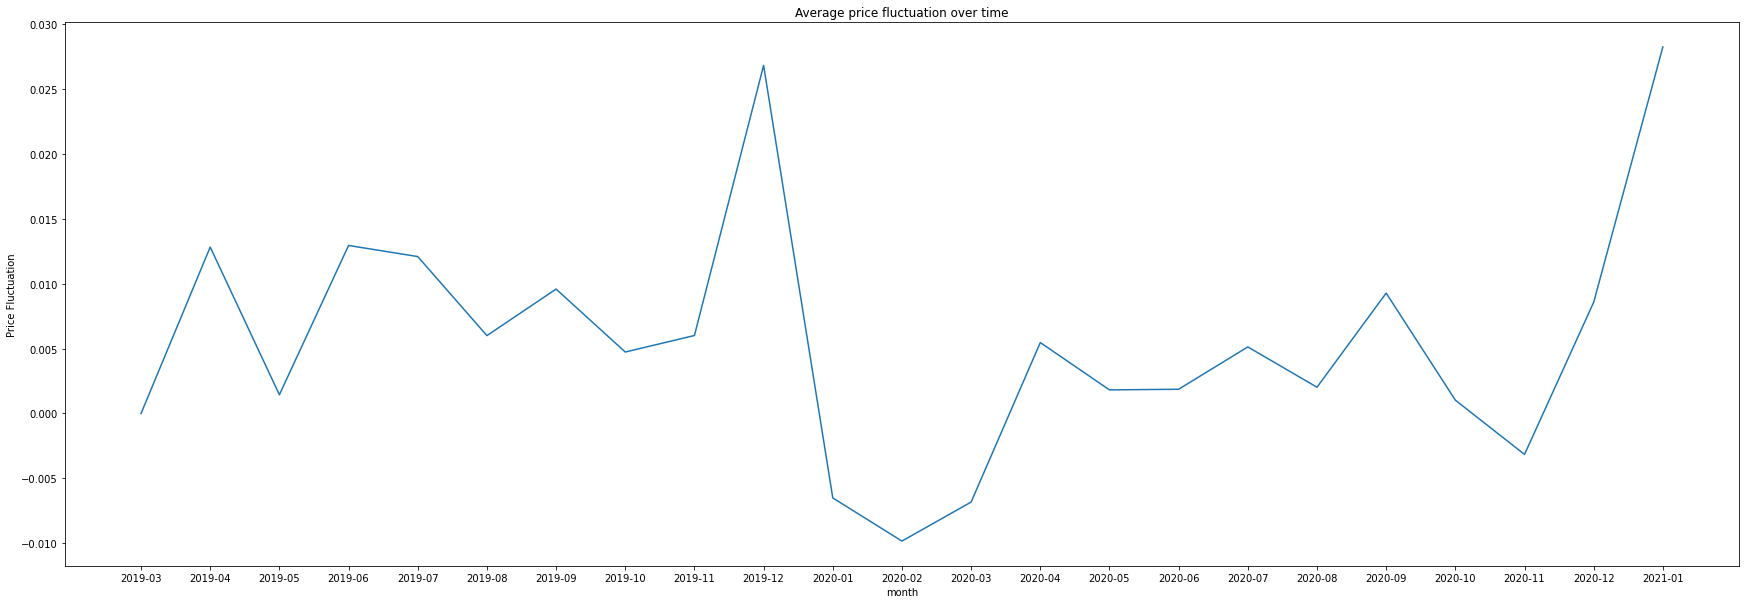

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 10))
plt.plot('month', 'mean_change_price_perc', data = calendars_change_df)
plt.title('Average price fluctuation over time')
plt.xlabel('month')
plt.ylabel('Price Fluctuation')